# Unsupervised Learning

In [1]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

## Principal Components Analysis
- Principal components are linear combinations of the predictor variables (__numeric data only__).
- Principal Components are calculated so as __to minimize correlation between components__, reducing redundancy.
- __A limited number of components will typically explain most of the variance in the outcome variable__.
- The limited set of principal components can then be used in place of the (more numerous) original predictors, reducing dimensionality.
- A superficially similar technique for __categorical__ data is __correspondence analysis__, but it is not useful in a big data context.

The idea in PCA is to combine multiple numeric predictor variables __into a smaller set of variables__, which are weighted linear combinations of the original set. The smaller set of variables, the __principal components__, "explain" most of the variability of the full set of variables, reducing the dimension of the data. The weights used to form the principal components reveal __the relative contributions of the original variables to the new principle components__. PCA can be viewed as the unsupervised version of linear distriminant analysis.

### Simple Example

For two variables, $X_1$ and $X_2$, there are two principal components $Z_i(i=1 \text{ or } 2)$:

$$
Z_i = w_i,_1X_1 + w_i,_2X_2
$$

The weights ($w_i,_1, w_i,_2)$ are known as the __component loadings__. These transform the original variables into the principle components. The first principle component, $Z_1$, is the linear combination that __best explains the total variation__. The second principal component, $Z_2$, is orthogonal to the first and explains as much of the remaining variation as it can (If there were additional components, each additional one would be orthogonal to the others). 

In [2]:
sp500_px = pd.read_csv('data/sp500_data.csv.gz', index_col=0)
oil_px = sp500_px[['XOM', 'CVX']]
print(oil_px.head())

                 XOM       CVX
1993-01-29 -0.016991  0.072921
1993-02-01  0.016991  0.102089
1993-02-02  0.084954  0.029168
1993-02-03  0.067964  0.058337
1993-02-04  0.034378  0.044272


In [3]:
pcs = PCA(n_components=2)
pcs.fit(oil_px)
loadings = pd.DataFrame(pcs.components_, columns=oil_px.columns)
print(loadings)

        XOM       CVX
0 -0.664711 -0.747101
1  0.747101 -0.664711


The weights for CVX and XOM for the first principal component are -0.747 and -0.665, and for the second principal component they are -0.665 and 0.747. __How to interpret this?__ The first principal component is essentially __an average of CVX and XOM__, reflecting the correlation between the two energy companies. The second principal component measures when the stock prices of CVX and XOM __diverge__.

It is instructive to plot the principal components with the data.

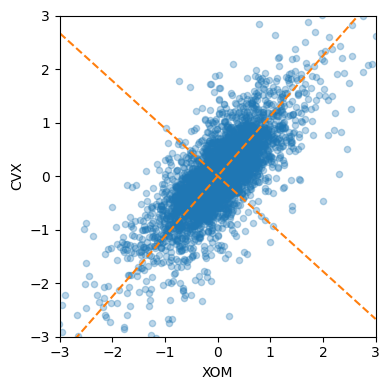

In [4]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3, figsize=(4, 4))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax),
        '--', color='C1')
ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax),
        '--', color='C1')

plt.tight_layout()
plt.show()

The dashed lines show the direction of the two principal components: the first one is along the long axis of the ellipse, and the second one is along the short axis. You can see that a majority of the variability in the two stock returns is explained by the first principal component. This makes sense since energy stock prices tend to move as a group.

The weights for the first principal component are both negative, but __reversing__ the sign of all the weights __does not change the principal component__. Using 0.747 and 0.665 is equivalent to the negative weights, just as an infinite line defined by the origin and 1,1 is the same as one defined by the origin and -1, -1.

### Computing the Principal Components
Going from two variables to more variables is straightforward. For the first component, simply include the additional predictor variables in the linear combination, __assigning weights that optimize the collection of the covariation__ from all the predictor variables into this first principal component. Calculation of principal components is a classic statistical method, relying on either the __correlation matrix__ of the data or the __covariance matrix__, and it executes rapidly, not relying on iteration. As noted earlier, principal components analysis works only with numeric variables, not categorical ones. The full process can be described as follows:
1. In creating the first principal compoient, PCA arrives at the linear combination of predictor variables that __maximizes the percent of total variance explained__.
2. This linear combination then becomes the first "new" predictor, $Z_1$.
3. PCA repeats this process, using the same variables with different weights, to create a second new predictor, $Z_2$. The weighting is done such that __$Z_1$ and $Z_2$ are uncorrelated__.
4. The process continues until you have as many new variables, or components, $Z_i$ as original variables $X_i$.
5. Choose to retain as many components as are needed to account for most of the variance.
6. The result so far is a set of weights for each component. The final step is to convert the original data into new principal component scores by applying the weights to the original values. These new scores can then be used as the reduced set of predictor variables.

### Interpreting Principal Components
The nature of the principal components often reveals __information about the structure of the data__. There are a couple of standard visualization displays to help you glean insight about the principal components. One such method is a __screeplot__ to visualize the relative importance of principal components.

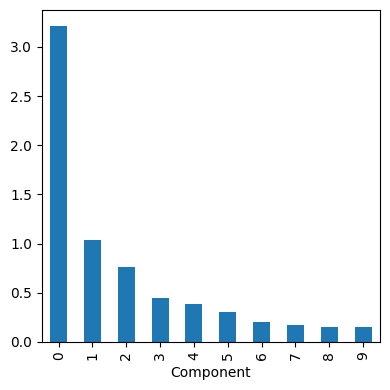

In [5]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
        'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]

sp_pca = PCA()
sp_pca.fit(top_sp)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

As seen in the chart above, the variance of the first principal component is quite large (as is often the case), but the other top principal components are significant.

It can be especially revealing to plot the weights of the top principal components.

       AAPL       AXP       COP      COST      CSCO       CVX        HD  \
0 -0.300825 -0.246332 -0.261529 -0.273634 -0.064059 -0.444490 -0.207983   
1 -0.505116 -0.139426  0.174212 -0.416307 -0.031939  0.289373 -0.278002   
2 -0.786730  0.135458 -0.002367  0.465862 -0.007524  0.082374  0.166320   
3 -0.120586  0.061814 -0.206026  0.092596  0.003904 -0.577665  0.162814   
4  0.111576 -0.596666 -0.005813  0.555529 -0.039860  0.109016 -0.185488   

       INTC       JPM      MSFT       SLB       TGT       USB       WFC  \
0 -0.076956 -0.196397 -0.105012 -0.481786 -0.148833 -0.116421 -0.145684   
1 -0.033898 -0.040723 -0.053954  0.472494 -0.228123 -0.054796 -0.047427   
2 -0.003518  0.062261  0.016248 -0.194822  0.160833  0.048976  0.041932   
3 -0.001605  0.057687 -0.012558  0.680914  0.109895  0.016752  0.018614   
4 -0.072047 -0.385160 -0.077135  0.181332 -0.055557 -0.155440 -0.216425   

        WMT       XOM  
0 -0.122304 -0.317952  
1 -0.222889  0.154192  
2  0.175806  0.090167  
3 

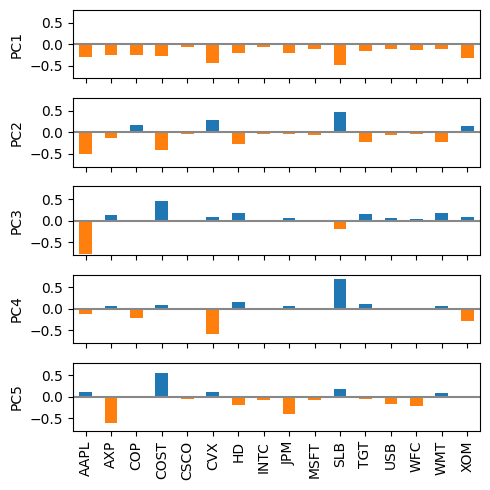

In [6]:
loadings = pd.DataFrame(sp_pca.components_[0:5, :], 
                        columns=top_sp.columns)
print(loadings)

maxPC = 1.01 * loadings.loc[0:5, :].abs().to_numpy().max()

f, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

The loadings for the top five components are shown above. The loadings for the first principal component have the same sign: this is typical for data in which all the columns share a common factor (in this case, the overall stock market trend). The second component captures the price changes of energy stocks as compared to the other stocks. The third component is primarily a contrast in the movements of Apple and CostCo. The fourth component contrasts the movements of Schlumberger (SLB) to the other energy stocks. Finally, the fifth component is mostly dominated by financial companies.

#### How many Components to Choose?
If your goal is to reduce the dimension of the data, you must decide __how many principal components to select__. The most common approach is to use an ad hoc rule to select the components that explain "most" of the variance. You can do this visually through the screeplot. Alternatively, you could select the top components such that __the cumulative variance exceeds a threshold__, such as 80%. Also, you can inspect the loadings to determine if the component has an intuitive interpretation. Cross-validation provides a more ormal method to select the number of significant components.

### Correspondence Analysis
PCA cannot be used for categorical data; however, a somewhat related technique is __correspondence analysis__. The goal is to recognize __associations between categories__, or between categorical features. The similarities between correspondence analysis and principal components analysis are mainly under the hood - the matrix algebra for dimension scaling. Correspondence analysis is used mainly for __graphical analysis of low-dimensional categorical data__ and not used in the same way that PCA is for dimension reduction as __a preparatory step with big data__. 

The input can be seen as a table, with rows representing one variable and columns another, and the cells representing record counts. The output (after some matrix algebra) is a __biplot__ - a scatterplot with axes scaled (and __with percentages indicating how much variance is explained by that dimension__). The meaning of the units on the axes is not intuitively connected to the original data, and the main value of the scatterplot is __to illustrate graphically variables that are associated with one another__ (by proximity on the plot). See for example the chart below, in which household tasks are arrayed according to whether they are done jointly or solo (vertical axis), and whether wife or husband has primary responsibility (horizontal axis). Correspondence analysis is many decades old, as is the spirit of this example, judging by the assignment of tasks.

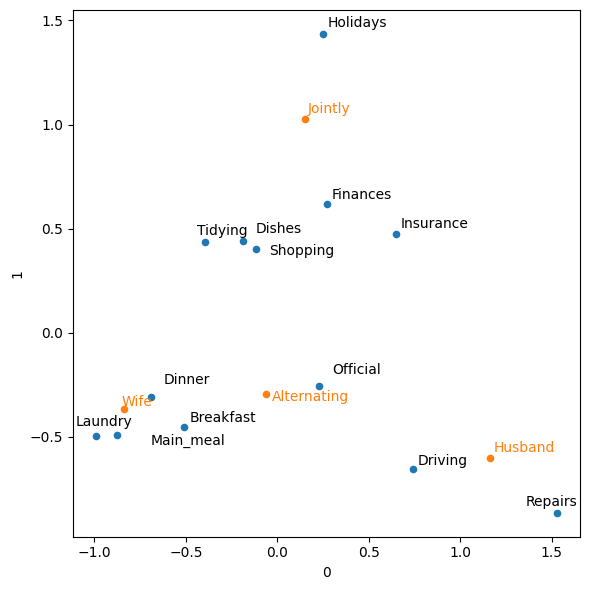

In [7]:
from adjustText import adjust_text

housetasks = pd.read_csv('data/housetasks.csv', index_col=0)

ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

ax = ca.row_coordinates(housetasks).plot.scatter(x=0, y=1, figsize=(6,6))
ca.column_coordinates(housetasks).plot.scatter(x=0, y=1, ax=ax, c='C1')
texts = []
for idx, row in ca.row_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx))
for idx, row in ca.column_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx, color='C1'))
adjust_text(texts, only_move={'points':'y', 'texts':'y'}) 
plt.tight_layout()
plt.show()

In [32]:
housetasks

,Wife,Alternating,Husband,Jointly
Task,,,,
Laundry,156,14,2,4
Main_meal,124,20,5,4
Dinner,77,11,7,13
Breakfast,82,36,15,7
Tidying,53,11,1,57
Dishes,32,24,4,53
Shopping,33,23,9,55
Official,12,46,23,15
Driving,10,51,75,3


## K-Means Clustering
- The number of desired clusters, $K$, is chosen by the user.
- The algorithm develops clusters by iteratively assigning records to the nearest cluster mean until cluster assignments do not change.
- Practical considerations usually dominate the choice of $K$; there is no statistically determined optimal number of clusters.

A goal of clustering is __to identify significant and meaningful groups of data__. The groups can be used directly, analyzed in more depth, or passed as a feature or an outcome to a predictive regression or classification model. 

$K$-means divides the data into $K$ clusters __by minimizing the sum of the squared distances of each record to the mean of its assigned cluster__. This is referred to as the within-cluster sum of squares or within-cluster SS. $K$-means does not ensure the clusters will have the same size but __finds the clusters that are the best separated__.

#### Normalization
It is typical to normalize continuous variables by subtracting the mean and dividing by the standard deviation. Otherwise, __variables with large scale will dominate the clustering process__.

### Simple Example
Start by considering a data set with $n$ records and just two variables, $x$ and $y$. Suppose we want to split the data into $K$ = 4 clusters. The means assigning each record $(x_i, y_i)$ to a cluster $k$. Given an assignment of $n_k$ records to cluster $k$, the center of the cluster $(\bar{x_k}, \bar{y_k})$ is __the mean of the points in the cluster__:

$$
\bar{x}_k = \frac{1}{n_k}\sum_{i \in \text{ Cluster } k}x_i
$$

$$
\bar{y}_k = \frac{1}{n_k}\sum_{i \in \text{ Cluster } k}y_i
$$

The sum of squares within a cluster is given by:

$$
SS_k = \sum_{i \in \text{ Cluster } k}{(x_i - \bar{x}_k)^2 + (y_i - \bar{y}_k)^2}
$$

$K$-means finds the assignment of records that __minimizes within-cluster sum of squares__ across all four clusters $SS_1 + SS_2 + SS_3 + SS_4$:

$$
\sum_{k = 1}^{4}SS_k
$$

A typical use of clustering is to locate natural, separate clusters in the data. Another application is to divide the data into a predetermined number of separate groups, where clustering is used to ensure the groups are as different as possible from one another. For example, suppose we want to divide daily stock returns into four groups. $K$-means clustering can be used to separate the data into the best groupings. Note that daily stock returns are reported in a fashion that is, in effect, standardized, so we do not need to normalize the data. 

#### Cluster Mean
In clustering records with __multiple variables__ (the typicall case), the term __cluster means__ refers not to a single number but to the vector of means of the variables.

In [8]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
kmeans = KMeans(n_clusters=4, n_init='auto').fit(df)

df['cluster'] = kmeans.labels_
print(df.head())

                 XOM       CVX  cluster
2011-01-03  0.736805  0.240681        0
2011-01-04  0.168668 -0.584516        1
2011-01-05  0.026631  0.446985        0
2011-01-06  0.248558 -0.919751        1
2011-01-07  0.337329  0.180511        0


In [9]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['XOM', 'CVX'])
print(centers)

        XOM       CVX
0  0.325846  0.449970
1 -0.286422 -0.492965
2 -1.123045 -1.718845
3  1.092072  1.581077


As the $K$-means algorithm uses __randomized__ starting points, the results may differ between subsequent runs and different implementations of the method. In general, you should check that the fluctuations aren't too large.

In this example, with just two variables, it is straightforward to visualize the clusters and their means:

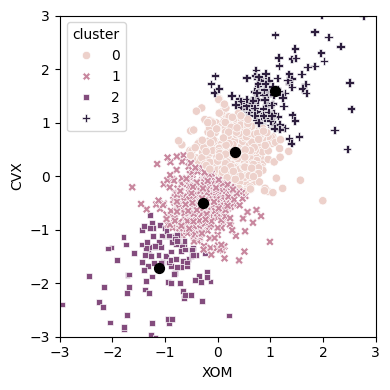

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.scatterplot(x='XOM', y='CVX', hue='cluster', style='cluster', 
                     ax=ax, data=df)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
centers.plot.scatter(x='XOM', y='CVX', ax=ax, s=50, color='black')

plt.tight_layout()
plt.show()

### K-Means Algorithm

In general, $K$-means can be applied to a data set with $p$ variables, $X_1,...,X_p$. While the exact solution to $K$-means is computationally very difficult, heuristic algorithms provide an efficient way to compute a __locally optimal solution__.

The algorithm starts with a user-specified $K$ and an initial set of cluster means and then iterates the following steps:
1. Assign each record to the nearest cluster mean as measured y squared distance.
2. Compute the new cluster means based on the assignment of records.

The algorithm __converges__ when the assignment of records to clusters does not change. For the first iteration, you need to specify an __initial set of cluster means__. Usually you do this by randomly assigning each record to one of the $K$ clusters and then finding the means of those clusters. 

Since this algorithm isn't guaranteed to find the best possible solution, __it is recommended to run the algorithm several times using different random samples to initialize the algorithm__. When more than one set of iterations is used, the $K$-means result is given by the iteration that has the __lowest within-cluster sum of squares__. The scikit-learn algorithm is repeated 10 times by default ("n_init"). The arguement "max_iter" (default 300) can be used to control the number of iterations.

In [11]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP', 
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
kmeans = KMeans(n_clusters=5, n_init='auto').fit(top_sp)

### Interpreting the Clusters
An important part of cluster analysis can involve the interpretation of the clusters. The two most important outputs from kmeans are __the size of the clusters__ and __the cluster means__. For the example in the previous subsection, the sizes of resulting clusters are given by using the "__collections.Counter__" class from the standard library in python.

In [12]:
from collections import Counter
print(Counter(kmeans.labels_))

Counter({4: 287, 2: 285, 0: 279, 3: 172, 1: 108})


The cluster sizes are relatively balanced. Imbalanced clusters can result from __distant outliers__, or from __groups of records very distant from the rest of the data__ - both may warrant further inspection.

You can plot the centers of the clusters:

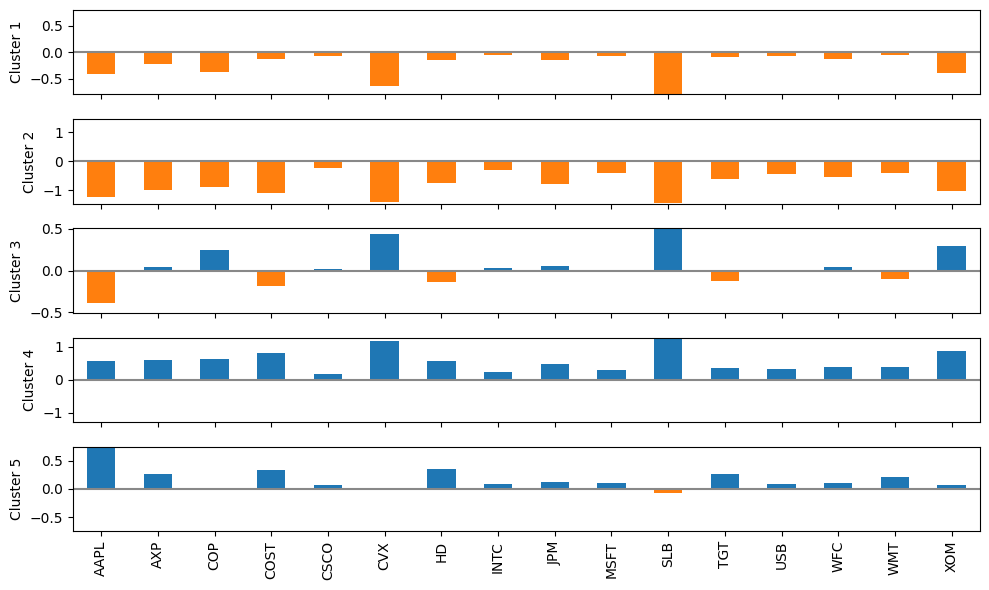

In [13]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=syms)

f, axes = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i + 1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

In [14]:
centers

,AAPL,AXP,COP,COST,CSCO,CVX,HD,INTC,JPM,MSFT,SLB,TGT,USB,WFC,WMT,XOM
0,-0.411766,-0.230393,-0.378887,-0.130476,-0.064414,-0.639437,-0.143378,-0.056842,-0.138153,-0.079442,-0.786451,-0.088734,-0.078414,-0.122985,-0.057322,-0.400033
1,-1.239329,-0.991787,-0.873717,-1.095094,-0.222967,-1.406244,-0.749802,-0.296751,-0.792721,-0.396047,-1.442577,-0.622236,-0.437006,-0.553957,-0.410872,-1.008356
2,-0.391912,0.048369,0.250044,-0.190938,0.014460,0.438129,-0.141700,0.027336,0.060638,0.006774,0.502412,-0.130573,0.011150,0.044237,-0.099838,0.291535
3,0.562723,0.597631,0.634961,0.802103,0.162062,1.170976,0.558503,0.226479,0.493291,0.291239,1.272965,0.356453,0.313913,0.375860,0.396142,0.873219
4,0.742778,0.259911,0.009739,0.330091,0.077321,-0.002963,0.360011,0.081126,0.122916,0.108895,-0.070113,0.268751,0.091458,0.098284,0.206430,0.074127


#### Cluster Analysis Versus PCA
The plot of cluster means is similar in spirit to looking at the loadings for principal components analysis (PCA). A major distinction is that unlike with PCA, __the sign of the cluster means is meaningful__. PCA identifies principal directions of variation, whereas cluster analysis finds groups of records located near one another.

### Selecting the Number of Clusters
The $K$-means algorithm requires that you specify the number of clusters $K$. Sometimes the number of clusters is driven by the application. For example, a company managing a sales force might want to cluster customers into "personas" to focus and guide sales calls. In such a case, managerial considerations would dictate the number of desired customer segments - for example, two might not yield useful differentiation of customers, while eight might be too many to manage. 

In the absence of a cluster number dictated by practical or managerial considerations, a statistical approach could be used. There is no single standard method to find the "best" number of clusters.

A coomon approach, called the  __elbow method__, is to identify __when the set of clusters explains "most" of the variance in the data__. __Adding new clusters beyond this set contributes relatively little in the variance explained__. The elbow is the point where the cumulative variance explained flattens out after rising steeply, hence the name of the method.

The chart below shows the cumulative percent of variance explained for the default data for the number of clusters ranging from 2 to 15. Where is the elbow in this example? There is no obvious candidate, since the incremental increase in variance explained drops gradually. __This is fairly typical in data that does not have well-defined clusters__. This is perhaps a drawback of the elbow method, but it does reveal the nature of the data.

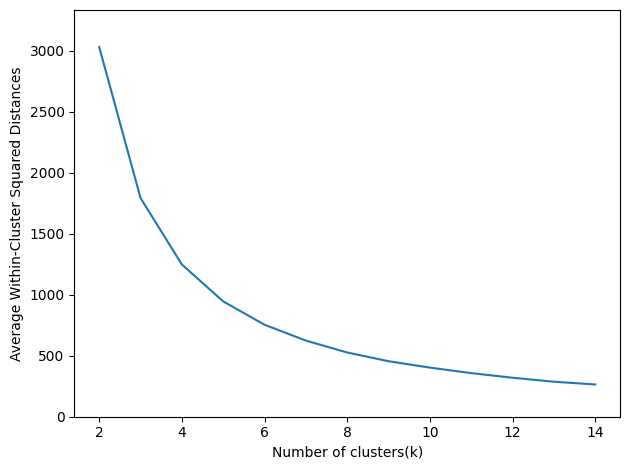

In [15]:
inertia = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(top_sp)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(2, 15), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In evaluating how many clusters to retain, perhaps the most important test is this: how likely are the clusters to be replicated on new data? Are the clusters interpretable, and do they relate to a general characteristic of the data, or do they just reflect a specific instance? You can assess this, in part, using cross-validation.

In general, there is no single rule that will reliably guide how many clusters to produce.

## Hierarchical Clustering
- Hierarchical clustering starts with every record in its own cluster.
- Progressively, clusters are joined to nearby clusters until all records belong to a single cluster (the agglomerative algorithm).
- The agglomeration history is retained and plotted, and the user (without specifying the number of clusters beforehand) can visualize the number and structure of clusters at different stages.
- Inter-cluster distances are computed in different ways, all relying on the set of all inter-record distances.

Hierarchical clustering is an alternative to $K$-means that can yield very different clusters. Hierarchical clustering allows the user to visualize __the effect of specifying different numbers of clusters__. It is more sensitive in discovering outlying or aberrant groups or records. Hierarchical clustering also lends itself to an intuitive graphical display, leading to easier interpretation of the clusters.

Hierarchical clustering's flexibility comes with a cost, and __hierarchical clustering does not scale well to large data sets__ with millions of records. For even modest-sized data, hierarchical clustering can require intensive computing resources. Indeed, most of the applications of hierarchical clustering are focusted on __relatively small data sets__.

### Simple Example
Hierarchical clustering works on a data set with $n$ records and $p$ variables and is based on two basic building blocks:
- A distance metric $d_i,_j$ to measure the distance between two records $i$ and $j$.
- A dissimilarity metric $D_A,_B$ to measure the difference between two clusters $A$ and $B$ based on the distances $d_i,_j$ between the members of each cluster.

For applications involving numeric data, the most important choice is __the dissimilarity metric__. Hierarchical clustering starts by setting each record as its own cluster and iterates __to combine the least dissimilar clusters__.

Clustering algorithms will cluster the records (rows) of a data frame. Since we want to cluster the companies, we need to transpose the data frame and put the stocks along the rows and the dates along the columns.

In [16]:
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD', 
         'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 'USB', 'WFC', 'WMT', 'XOM']
df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()

Z = linkage(df, method='complete')
print(Z.shape)

(17, 4)


Hierarchical clustering lends itself to a natural graphical display as a tree, referred to as a __dendrogram__. 

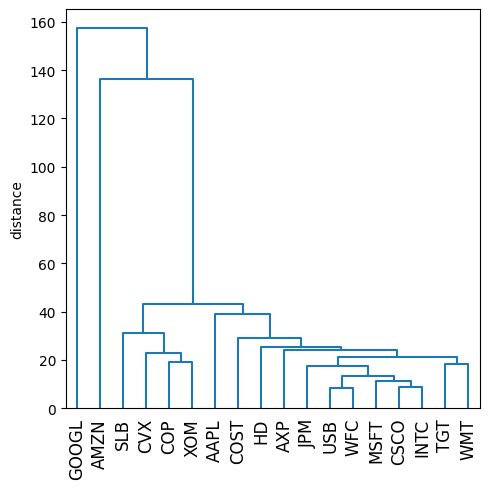

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z, labels=list(df.index), color_threshold=0)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

plt.tight_layout()
plt.show()

Note that we are now plotting companies that are similar to one another, not days. The leaves of the tree correspond to the records. The length of the branch in the tree indicates __the degree of dissimilarity between corresponding clusters__. The returns for Google and Amazon are quite dissimilar to one another and to the returns for the other stocks. The oil stocks (SLB, CVX, XOM, COP) are in their own cluster, AAPL is by itself, and the rest are similar to one another.

In contrast to $K$-means, __it is not necessary to prespecify the number of clusters__. Graphically, you can identify different numbers of clusters with a horizontal line that slides up or down; a cluster is defined wherever the horizontal line intersects the vertical lines. To extract a specific number of clusters, you can use the "fcluster" method.

In [18]:
memb = fcluster(Z, 4, criterion='maxclust')
memb = pd.Series(memb, index=df.index)
for key, item in memb.groupby(memb):
    print(f"{key} : {', '.join(item.index)}")

1 : COP, CVX, SLB, XOM
2 : AAPL, AXP, COST, CSCO, HD, INTC, JPM, MSFT, TGT, USB, WFC, WMT
3 : AMZN
4 : GOOGL


### The Agglomerative Algorithm
The main algorithm for hierarchical clustering is the __agglomerative__ algorithm, which iteratively __merges similar clusters__. The agglomerative algorithm begins with each record constituting its own single record cluster and then builds up larger and larger clusters. The first step is to calculate distances between all pairs of records.

For each pair of records $(x_1, x_2,..., x_p)$ and $(y_1, y_2,..., y_p)$, we measure the distance between the two records, $d_x,_y$, using a distance metric. For example, we can use Euclidian distance:

$$
d(x,y) = \sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2 +...+ (x_p - y_p)^2}
$$

We now turn to inter-cluster distance. Consider two clusters $A$ and $B$, each with a distinctive set of records, $A = (a_1, a_2,...,a_m)$ and $B = (b_1, b_2,...,b_q)$. We can measure the dissimilarity between the clusters $D(A, B)$ by using the distances between the members of $A$ and the members of $B$.

One measure of dissimilarity is the __complete-linkage__ method, which is __the maximum distance across all pairs of records between $A$ and $B$__:

$$
D(A,B) = \text{max } d(a_i, b_j) \text{ for all pairs } i,j 
$$

This defines the dissimilarity as the biggest difference between all pairs.

The main steps of the agglomerative algorithm are:
1. Create an initial set of clusters with each cluster consisting of a single record for all records in the data.
2. Compute the dissimilarity $D(C_k, C_l)$ between all pairs of clusters $k, l$.
3. Merge the two clusters $C_k$ and $C_l$ that are __least dissimilar__ as measured by $D(C_k, C_l)$.
4. If we have more than one cluster remaining, return to step 2. Otherwise, we are done.

### Measures of Dissimilarity
There are four common measures of dissimilarity: __complete linkage__, __single linkage__, __average linkage__, __minimum variance__. These (plus other measures) are all supported by most hierarchical clustering software. The complete linkage method defind earlier tends to produce clusters with members that are similar. The single linkage method is the minimum distance between the records in two clusters:

$$
D(A,B) = \text{min } d(a_i, b_j) \text{ for all pairs } i, j
$$

This is a "greedy" method and produces clusters that can contain quite disparate elements. The average linkage method is the average of all distance pairs and represents a compromise between the single and complete linkage methods. Finally, the minimum variance method, also referred to as __Ward's__ method, is similar to $K$-means since it minimizes the within-cluster sum of squares. The chart below applies hierarchical clustering using the four measures to the ExxonMobil and Chevron stock returns.

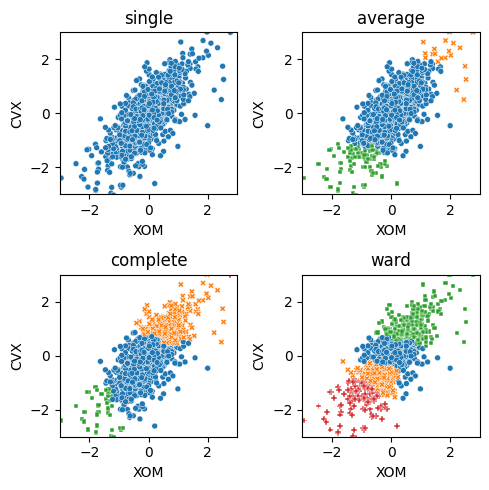

In [19]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
for i, method in enumerate(['single', 'average', 'complete', 'ward']):
    ax = axes[i // 2, i % 2]
    Z = linkage(df, method=method)
    colors = [f'C{c+1}' for c in fcluster(Z, 4, criterion='maxclust')]
    ax = sns.scatterplot(x='XOM', y='CVX', hue=colors, style=colors,
                         size=0.5, ax=ax, data=df, legend=False)

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title(method)

plt.tight_layout()
plt.show()

## Model-Based Clustering
- Clusters are assumed to derive from different data-generating processes with different probability distributions.
- Different models are fit, assuming different numbers of (typically normal) distributions.
- The method chooses the model (and the associated number of clusters) that fits the data well without uisng too many parameters (i.e., overfitting).

### Multivariate Normal Distribution
The most widely used model-based clustering methods is the __multivariate normal distribution__. The multivariate normal distribution is a generalization of the normal distribution to a set of $p$ variables $X_1, X_2,...,X_p$. The distribution is defined by a set of means $\mu = \mu_1, \mu_2,...,\mu_p$ and a covariance matrix $\sum$. The convariance matrix is a measure of how the variables correlate with each other. The covariance matrix $\sum$ consists of $p$ variances $\sigma^2_1, \sigma^2_2,...,\sigma^2_p$ and covariances $\sigma_i,_j$ for all pairs of variables $i \neq j$.

Note that the covariance matrix is symmetric around the diagonal from upper left to lower right. Since $\sigma_i,_j = \sigma_j,_i$, there are only $(p*(p-1))/2$ covariance terms. In total, the covariance matrix has $(p*(p-1))/2 + p$ parameters. The distribution is denoted by:

$$
(X_1, X_2,...,X_p) \sim N_p(\mu, \Sigma)
$$

This is a symbolic way of saying that __the variables are all normally distributed__, and __the overall distribution is fully described by the vector of variable means and the covariance matrix__.

The chart below shows the probability contours for a multivariate normal distribution for two variables $X$ and $Y$ (the 0.5 probability contour, for example, contains 50% of the distribution).

The means are $\mu_x$ = 0.5 and $\mu_y$ = -0.5, and the covariance matrix is:

$$
\Sigma = \begin{array}{ccc}
1 & 1 \\
1 & 2 \\
\end{array}
$$

Since the covariance $\sigma_{xy}$ is positive, $X$ and $Y$ are positively correlated.

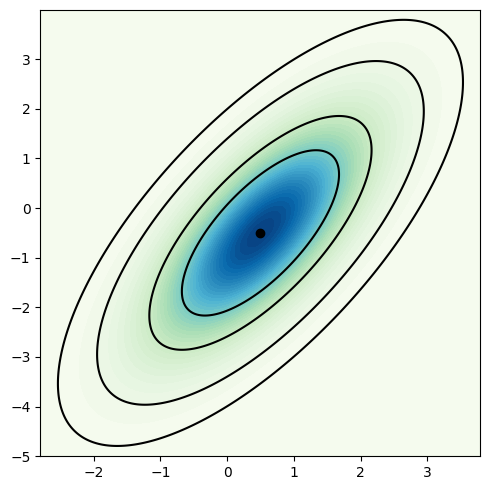

In [20]:
mean = [0.5, -0.5]
cov = [[1, 1], [1, 2]]
probability = [.5, .75, .95, .99]
def probLevel(p):
    D = 1
    return (1 - p) / (2 * math.pi * D)
levels = [probLevel(p) for p in probability]

fig, ax = plt.subplots(figsize=(5, 5))

x, y = np.mgrid[-2.8:3.8:.01, -5:4:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mean, cov)


CS = ax.contourf(x, y, rv.pdf(pos), cmap=cm.GnBu, levels=50)
ax.contour(CS, levels=levels, colors=['black'])
ax.plot(*mean, color='black', marker='o')


plt.tight_layout()
plt.show()

### Mistures of Normals
The key idea behind model-based clustering is that __each record is assumed to be distributed as one of $K$ multivariate normal distributions__, where $K$ is the number of clusters. Each distribution has a different mean $\mu$ and covariance matrix $\Sigma$. For example, __if you have two variables, $X$ and $Y$, then each row $(X_i, Y_i)$ is modeled as having been sampled from one of $K$ multivariate normal distributions $N(\mu_1, \Sigma_1), N(\mu_2, \Sigma_2),...,N(\mu_K, \Sigma_K)$__.

In [21]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
mclust = GaussianMixture(n_components=2).fit(df)
print(mclust.bic(df))

4589.3203170532615


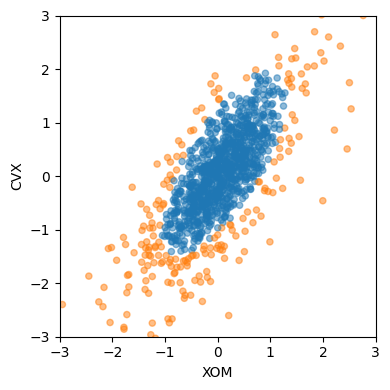

In [22]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = [f'C{c}' for c in mclust.predict(df)]
df.plot.scatter(x='XOM', y='CVX', c=colors, alpha=0.5, ax=ax)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

There are two clusters: one cluster in the middle of the data, and a second cluster in the outer edge of the data. This is very different from the clusters obtained using $K$-means and hierarchical clustering, which find clusters that are compact.

You can extract the parameters to the normal distributions:

In [23]:
print('Mean')
print(mclust.means_)
print('Covariances')
print(mclust.covariances_)

Mean
[[ 0.0709161   0.10228006]
 [-0.05074943 -0.21539465]]
Covariances
[[[0.27074158 0.27800893]
  [0.27800893 0.5212865 ]]

 [[0.98668327 0.99350046]
  [0.99350046 1.69695919]]]


The distributions have similar means and correlations, but the second distribution has much larger variances and covariances. Due to the randomness of the algorithm, results can vary slightly between different runs.

The goal of model-based clustering is to find the best-fitting set of multivariate normal distributions. The stock data appears to have a normal looking shape: see the contours of the chart above. In fact, though, stock returns have a longer-tailed distribution than a normal distribution. To handle this, the algorithm fits a distribution to the bulk of the data but then fits a second distribution with a bigger variance.

### Selecting the Number of Clusters
Unlike $K$-means and hierarchical clustering, mclust automatically selects the number of clusters. It does this __by choosing the number of clusters for which the Bayesian Information Criteria (BIC) has the largest value__ (BIC is similar to AIC). BIC works __by selecting the best-fitting model with a penalty for the number of parameters in the model__. In the case of model-based clustering, adding more clusters will always improve the fit at the expense of introducing additional parameters in the model.

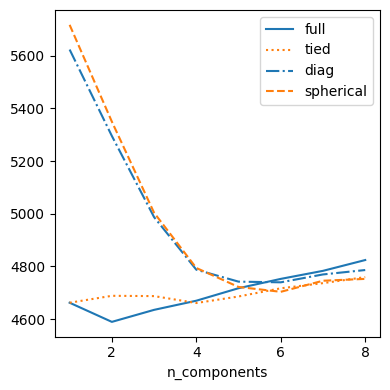

In [24]:
results = []
covariance_types = ['full', 'tied', 'diag', 'spherical']
for n_components in range(1, 9):
    for covariance_type in covariance_types:
        mclust = GaussianMixture(n_components = n_components, warm_start=True, #1
                                 covariance_type = covariance_type)
        mclust.fit(df)
        results.append({
            'bic': mclust.bic(df),
            'n_components': n_components,
            'covariance_type': covariance_type,
        })
        
results = pd.DataFrame(results)

colors = ['C0', 'C1', 'C2', 'C3']
styles = ['C0-','C1:','C0-.', 'C1--']

fig, ax = plt.subplots(figsize=(4, 4))
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type, 
                kind='line', style=styles[i]) # , color=colors[i])

plt.tight_layout()
plt.show()

#1
# With the warm_start argument, the calculation will reuse information from the previous fit. 
# This will speed up the convergence of subsequent calculations.bm

This plot is similar to the elbow plot used to identify the number of clusters to choose for $K$-means, except the value being plotted is BIC instead of percent of variance explained. 

Model-based clustering techniques do have some limitations. The methods require an underlying assumption of a model for the data, and the cluster results are very dependent on that assumption. The computations requirements are higher than even hierarchical clustering, making it difficult to scale to large data. Finally, the algorithm is more sophisticated and less accessible than that of other methods.

## Scaling and Categorical Variables
- Variables measured on different scales need to be transformed to similar scales __so that their impact on algorithm is not determined mainly by their scale__.
- A coomon scaling method is normalization (standardization) - subtracting the mean and dividing by the standard deviation.
- Another method is Gower's distance, which scales all variables to the 0-1 range (it is often used with mixed numeric and categorical data).

Unsupervised learning techniques generally require that __the data be approximately scaled__. This is different from many of the techniques for regression and classification in which scaling is not important (an exception is KNN). If the data is not scaled, then the PCA, $K$-means, and other clustering methods __will be dominated by the variables with large values and ignore the variables with small values__. 

__Categorical data can pose a special problem for some clustering procedures__. As with KNN, unordered factor variables are generally converted to a set of binary (0/1) variables using one hot encoding. Not only are the binary variables likely on a different scale from other data, but the fact that binary variables have only two values can prove problematic with techniques such as PCA and $K$-means.

### Scaling the Variables
Variables with very different scale and units need to be normalized approximately before you apply a clustering procedure. For example, let's apply kmeans to a set of data of loan defaults without normalizing:

In [25]:
loan_data = pd.read_csv('data/loan_data.csv.gz')
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)
defaults = loan_data.loc[loan_data['outcome'] == 'default',]

columns = ['loan_amnt', 'annual_inc', 'revol_bal', 'open_acc', 
           'dti', 'revol_util']

df = defaults[columns]
kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

      loan_amnt     annual_inc     revol_bal   open_acc        dti  \
0  17809.760881   78669.452556  18933.405997  11.594003  17.016428   
1  21444.318867  148736.057263  33152.689572  12.376733  13.831145   
2  24290.909091  409746.465909  84710.988636  13.431818   8.148636   
3  10274.160906   41241.205530   9950.095008   9.480338  17.718588   

   revol_util   size  
0   62.183810   7906  
1   63.151084   1654  
2   60.015647     88  
3   57.903425  13023  


The variables "annual inc" and "revol_bal" dominate the clusters, and the clusters have very different sizes. Cluter 2 only has 88 members with comparatively high income and revolving credit balance. 

A common approach to scaling the variables is to convert them to z-scores. This is termed __standardization__ or __normalization__:

$$
z = \frac{x - \bar{x}}{s}
$$

In [26]:
scaler = preprocessing.StandardScaler()
df0 = scaler.fit_transform(df * 1.0)

kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df0)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

      loan_amnt     annual_inc     revol_bal   open_acc        dti  \
0  13484.728906   55907.993263  16435.803337  14.322265  24.211535   
1  25950.205142  116834.142232  32945.972921  12.396335  16.165914   
2  10507.283093   51117.994063  11635.285252   7.509513  15.931561   
3  10324.846369   53456.824767   6054.819926   8.664618  11.312983   

   revol_util  size  
0   59.463608  6244  
1   66.123542  3670  
2   77.795077  7397  
3   30.999874  5360  


The cluster sizes are more balanced, and the clusters are not dominated by "annual_inc" and "revol_bal," revealing more interesting structure in the data. Note that the centers are rescaled to the original unitis in the preceding code. If we had left them unscaled, the resulting values would be in terms of z-scores and would therefore be less interpretable.

__Scaling is also important for PCA__. Using the z-score is equivalentto using the correlation matrix insteadh of the covariance matrix in computing the principal components. Software to compute PCA usually has an option to use the correlation matrix.

### Dominant Variables
Even in cases where the variables are measures on the same scale and accurately reflect relative importance (e.g., movement to stock prices), it can sometimes be useful to rescale the variance. 

Suppse we add Google and Amazon to the analysis in "Interpreting Principal Compenents."

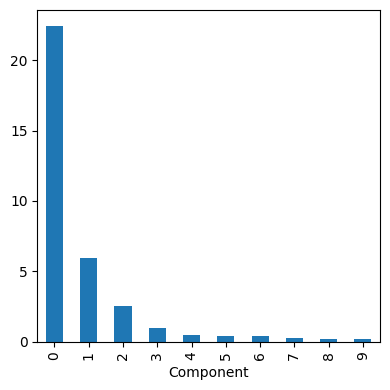

In [27]:
syms = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 
        'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST']
top_sp1 = sp500_px.loc[sp500_px.index >= '2005-01-01', syms]

sp_pca1 = PCA()
sp_pca1.fit(top_sp1)

explained_variance = pd.DataFrame(sp_pca1.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

The screeplot displays the variances for the top principal components. In this case, the screeplot reveals that the variances of the first and second components are much larger than the others. This often indicates that one or two variables dominate the loadings. This is indeed the case i this example:

In [28]:
loadings = pd.DataFrame(sp_pca1.components_[0:2, :], 
                        columns=top_sp1.columns)
print(loadings.transpose())

              0         1
GOOGL -0.857310  0.477873
AMZN  -0.444728 -0.874149
AAPL  -0.071627 -0.020802
MSFT  -0.036002 -0.006204
CSCO  -0.029205 -0.003045
INTC  -0.026666 -0.006069
CVX   -0.089548 -0.037420
XOM   -0.080336 -0.020511
SLB   -0.110218 -0.030356
COP   -0.057739 -0.024117
JPM   -0.071228 -0.009244
WFC   -0.053228 -0.008597
USB   -0.041670 -0.005952
AXP   -0.078907 -0.024027
WMT   -0.040346 -0.007141
TGT   -0.063659 -0.024662
HD    -0.051412 -0.032922
COST  -0.071403 -0.033826


The first two principal components are almost completely dominated by Google and Amazon. This is because the stock price movements of Google and Amazon dominate the variability. To handle this situation, you can either include them as is, rescale the variables, or exclude the dominant variables from the analysis and handle them separately. There is no "correct" approach, and the treatment depends on the application.

### Categorical Data and Gower's Distance
In the case of categorical data, you must convert it to numeric data, either by ranking (for an ordered factor) or by encoding as a set of binary variables. If the data consists of mixed continuous and binary variables, you will usually want to scale the variables so that the ranges are similar. One popular method is to use Gower's distance.

The basic idea behind Gower's distance is to apply a different distance metric to each variable depending on the type of data:
- For numeric variables and ordered factors, distanceis calculated as the absolute value of the difference between two records (Manhattan distance).
- For categorical variables, the distance is 1 if the categories between two records are different, and the distance is 0 if the categories are the same.

Gower's distance is computed as follows:
1. Compute the distance $d_i,_j$ for all pairs oof variables $i$ and $j$ for each record.
2. Scale each pair $d_i,_j$ so the minimum is 0 and the maximum is 1.
3. Add the pairwise scaled distances between variables together, using either a simple or a weighted mean, to create the distance matrix.

***At the moment of the publication of the book, Gower's distance is not available in any of the popular Pyton packages. However, activities are ongoing to include it in scikit-learn. 

### Problems with Clustering Mixed Data


$K$-means and PCA are most appropriate for continuous variables. For smaller data sets, it is better to use hierarchical clustering with Gower's distance. In principle, there is no reason why $K$-means can't be applied to binary or categorical data. You would usually use the "one hot encode" representation to convert the categorical data to numeric values. In practice, however, using $K$-means and PCA with binary data can be difficult.

If the standard z-scores are used, the binary variables withh dominate the definition of the clusters. This is because 0/1 variables take on only two values, and $K$-means can obtain a small within-cluster sum-of-squares by assigning all the records with a 0 or 1 to a single cluser.

In [29]:
columns = ['dti', 'payment_inc_ratio', 'home_', 'pub_rec_zero']
df = pd.get_dummies(defaults[columns], dtype=int)

scaler = preprocessing.StandardScaler()

df0 = scaler.fit_transform(df * 1.0)
kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df0)
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=df.columns)
print(centers)

         dti  payment_inc_ratio  pub_rec_zero  home__MORTGAGE     home__OWN  \
0  21.431365          12.354001      0.943315   -1.942890e-15  4.718448e-16   
1  12.743276           5.918701      0.900372   -1.276756e-15  1.526557e-16   
2  17.339786           8.353535      0.905716    1.000000e+00 -5.273559e-16   
3  17.197993           9.266666      0.917903    1.054712e-15  1.000000e+00   

     home__RENT  
0  1.000000e+00  
1  1.000000e+00  
2 -4.163336e-15  
3 -2.775558e-16  


The top four clusters are essentially proxies for the different levels of the factor variables. To avoid this behavior, you could scale the binary variables to have a smaller variance than other variables. Alternatively, for very large data sets, you could apply clustering to different subsets of data taking on specific categorical values. For example, you could apply clustering separately to those loans made to someone who has a mortgage, owns a home outright, or rents.